In [28]:
from matplotlib.cbook import to_filehandle
#@title { run: "auto" }
import numpy as np
import pylab as p
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from scipy import integrate, optimize
#The Model Class
class speedGraph:
    def __init__(self, model, initValues, varNames, plotVars, tInit=0, tFinal=300, tSpace=1000):
        self.EQTOLERANCE = 5
        self.model = model
        self.initValues = initValues
        self.tInit = tInit
        self.tFinal = tFinal
        self.tSpace = tSpace
        self.varNames = varNames
        self.plotVars = plotVars

        # Initialize time and data
        self.X0 = np.array(initValues)
        self.t = np.linspace(tInit, tFinal, tSpace)
        self.data = {name: np.zeros(self.t.size) for name in varNames}  # Store all variables

        # Compute the data from odeint
        X = integrate.odeint(model, self.X0, self.t)
        for i, name in enumerate(varNames):
            self.data[name] = X[:, i]  # Store each variable

        # Extract variables for plotting
        self.x = self.data[self.plotVars[0]]
        self.y = self.data[self.plotVars[1]]

        # Calculate velocities for all variables
        self.vel_components = np.zeros((self.t.size, len(varNames)))
        for ts in range(self.t.size):
            self.vel_components[ts] = self.model(X[ts])  # Velocity for all variables at time step `ts`

        # Calculate velocity magnitude
        self.vel = np.sqrt(np.sum(self.vel_components**2, axis=1))

        # Calculate equilibrium points
        self.eqPoints = self.calcEquillibriumPoints()

    def calcEquillibriumPoints(self, decimals=2):
        """
        Find the equilibrium points of the system for an arbitrary number of variables.
        """
        # Generate a grid of initial points for optimization
        ranges = [
            np.linspace(
                self.data[var].min() - self.EQTOLERANCE,
                self.data[var].max() + self.EQTOLERANCE,
                10
            )
            for var in self.varNames
        ]

        # Create a meshgrid for all variable combinations
        grid = np.array(np.meshgrid(*ranges)).T.reshape(-1, len(self.varNames))

        # Find equilibrium points using optimization
        eqPoints = []
        for initial_point in grid:
            root = optimize.root(self.model, initial_point).x
            eqPoints.append(root)

        # Round the results and remove duplicates
        return np.unique(np.around(eqPoints, decimals=decimals), axis=0)

    #Set up the graphs
    def plotGraphs(self, with_eqs = False):
        pa = 'Uninfected Cells'
        pb = 'Infected Cells'
        pc = 'Phase plane'
        figs, axs = plt.subplot_mosaic([
            [[[pa],[pb]],pc]
        ],
        width_ratios=[1,1])
        self.figs=figs
        self.axs=axs
        #Calculate data for colour map
        #The code is mostly from here https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
        #This is the location of the points on the line
        points = np.array([self.x, self.y]).T.reshape(-1, 1, 2)
        #Turn the points into line segments
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        #Create the norm
        norm = plt.Normalize(self.vel.min(), self.vel.max())
        #Join the segments into a line Collection
        lc = LineCollection(segments, cmap='jet', norm=norm)
        # Set the values used for colormapping
        lc.set_array(self.vel)
        lc.set_linewidth(2)
        #Graph to the phaseplane
        line = axs[pc].add_collection(lc)
        figs.colorbar(line, ax=axs[pc])
        #Plotting the phase plane
        #Initial Condition
        axs[pc].plot(self.x[0],self.y[0],'ro')
        #Fixed points
        if with_eqs:
            for fixed in self.eqPoints:
                axs[pc].plot(fixed[0],fixed[1],'rP')
        #Labels
        axs[pc].set_xlabel(self.plotVars[0])
        axs[pc].set_ylabel(self.plotVars[1])
        #Plotting functions of time
        axs[pa].plot(self.t,self.x, 'b-', label=self.plotVars[0])
        axs[pa].set_ylabel('x')
        axs[pb].plot(self.t,self.y, 'r-', label=self.plotVars[1])
        axs[pb].set_xlabel('time')
        axs[pb].set_ylabel('y')
        #Place the legend
        for title, ax in axs.items():
            ax.grid()
            ax.legend(loc='best')
'''
#The method for producing the graph of a given model with speed
def speedGraphModel(model, initValues, tInit=0, tFinal=1000, tSpace=100000):
  #Initialize the Data
  X0 = np.array(initValues)
  t=np.linspace(tInit, tFinal, tSpace)
  #Compute the data from odeint
  X = integrate.odeint(model, X0, t)
  x, y = X.T
  #Find the equillibrium points
  E0 = optimize.root(model, [1/D, 0]) #Recovered equillibrium
  E1 = optimize.root(model, [1/D, 0]) #E+ equillibrium
  E2 = optimize.root(model, [1/D, 0]) #E- equillibrium
  #Set up the graphs
  pa = 'Uninfected Cells'
  pb = 'Infected Cells'
  pc = 'Phase plane'
  figs, axs = plt.subplot_mosaic([
      [[[pa],[pb]],pc]
  ],
  width_ratios=[1,1])
  #Calculate data for colour map
  #The code is mostly from here https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
  #Define and calculate velocity by passing to the model
  velx = np.zeros(t.size)
  vely = np.zeros(t.size)
  for ts in range(t.size):
    velx[ts] = model([x[ts],y[ts]])[0]
    vely[ts] = model([x[ts],y[ts]])[1]
  vel = np.sqrt(velx**2 + vely**2)
  #This is the location of the points on the line
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  #Turn the points into line segments
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  #Create the norm
  norm = plt.Normalize(vel.min(), vel.max())
  #Join the segments into a line Collection
  lc = LineCollection(segments, cmap='jet', norm=norm)
  # Set the values used for colormapping
  lc.set_array(vel)
  lc.set_linewidth(2)
  #Graph to the phaseplane
  line = axs[pc].add_collection(lc)
  figs.colorbar(line, ax=axs[pc])
  #Plotting the phase plane
  #axs[pc].plot(x,y)
  axs[pc].plot(x[0],y[0],'ro')
  axs[pc].set_xlabel('x')
  axs[pc].set_ylabel('y')
  #Plotting functions of time
  axs[pa].plot(t,x, 'b-', label='Uninfected cell density')
  axs[pa].set_ylabel('x')
  axs[pb].plot(t,y, 'r-', label='Infected cell density')
  axs[pb].set_xlabel('time')
  axs[pb].set_ylabel('y')
  #Place the legend
  for title, ax in axs.items():
    ax.grid()
    ax.legend(loc='best')

  #Set the title
  axs[pc].set_title(f'2-Dim model at a={a}, b={b}, c={c}, d={d}')'''

"\n#The method for producing the graph of a given model with speed\ndef speedGraphModel(model, initValues, tInit=0, tFinal=1000, tSpace=100000):\n  #Initialize the Data\n  X0 = np.array(initValues)\n  t=np.linspace(tInit, tFinal, tSpace)\n  #Compute the data from odeint\n  X = integrate.odeint(model, X0, t)\n  x, y = X.T\n  #Find the equillibrium points\n  E0 = optimize.root(model, [1/D, 0]) #Recovered equillibrium\n  E1 = optimize.root(model, [1/D, 0]) #E+ equillibrium\n  E2 = optimize.root(model, [1/D, 0]) #E- equillibrium\n  #Set up the graphs\n  pa = 'Uninfected Cells'\n  pb = 'Infected Cells'\n  pc = 'Phase plane'\n  figs, axs = plt.subplot_mosaic([\n      [[[pa],[pb]],pc]\n  ],\n  width_ratios=[1,1])\n  #Calculate data for colour map\n  #The code is mostly from here https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html\n  #Define and calculate velocity by passing to the model\n  velx = np.zeros(t.size)\n  vely = np.zeros(t.size)\n  for ts in range(t.s

Below is a simulation of the linear infectivity model
$$
\begin{cases}
 x' &= 1 - Dx - \left(ky+B\right)xy \\
 y' &= \left(ky+B\right)xy - y.
 \end{cases}
 $$
You can change the initial conditions with the $x_0,y_0$ slider as well as the parameters. Included in the output is time series of the solutions $x,y$ as well as the phase plane. The phase plane includes the speed of the solution as the colour (red is faster) as well as a numerical estimate of the fixed points indicated by the red plus.

<ipython-input-17-1da04cef0708>:117: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


[[ 2.720e+00  8.400e-01]
 [ 1.754e+01 -0.000e+00]
 [ 1.771e+01 -1.000e-02]]


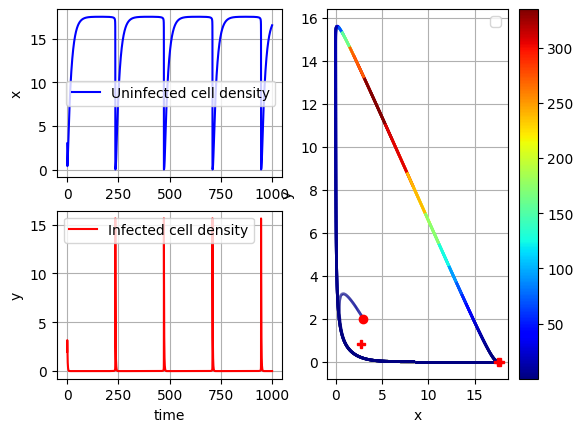

In [18]:
#@title { run: "auto" }
"""
Default values for recurrence are
k = 0.364
B = 0.060, Bifurcation of trivial equilibrium at (stable to unstable) at B=D.
D = 0.057
"""
#Parameters
k = 0.364 #@param {type:"slider", min:0, max:1, step:0.001}
b = 0.060 #@param {type:"slider", min:0, max:1, step:0.001}
d = 0.057 #@param {type:"slider", min:0, max:0.3, step:0.001}
#initial conditions
x0 = 3 #@param {type:"slider", min:0, max:50, step:0.5}
y0 = 2 #@param {type:"slider", min:0, max:50, step:0.5}
X0 = np.array([x0,y0])
"""Define the ODE
X           - the state vector
infectivity - is a function beta(y)
t           - time
a, b, c, d  - parameters
"""

def linearModel(X,t=0):
    x=X[0]
    y=X[1]
    return np.array([1-d*x-(k*y+b)*x*y, (k*y+b)*x*y - y])

linMod = speedGraph(linearModel, X0, ['x','y'], ['x','y'])
linMod.plotGraphs()
'''plt.plot(linMod.t, 1/(a*linMod.t)-b/a,'y--')
linMod.axs['Phase plane'].set_ylim(-1,15)
linMod.axs['Phase plane'].set_xlim(-1,20)'''
print(linMod.eqPoints)

In [ ]:
#@title { run: "auto" }

#Parameters
alpha = 1 #@param {type:"slider", min:0, max:1, step:0.001}
K = 50  #@param {type:"slider", min:0, max:90, step:0.001}
rho = 9 #@param {type:"slider", min:0, max:15, step:0.001}
b1 = 1  #@param {type:"slider", min:0, max:5, step:0.001}
b2 = 1  #@param {type:"slider", min:0, max:5, step:0.001}
b3 = 1  #@param {type:"slider", min:0, max:5, step:0.001}
b4 = 1  #@param {type:"slider", min:0, max:5, step:0.001}
b5 = 1  #@param {type:"slider", min:0, max:5, step:0.001}
b6 = 0.1 #@param {type:"slider", min:0, max:90, step:0.001}
#initial conditions
X0 = np.array([1,0,0,0,0,0])
"""Define the ODE
X           - the state vector
infectivity - is a function beta(y)
t           - time
a, b, c, d  - parameters
"""

def bio_model(X,t=0):
    S1=X[0]
    S2=X[1]
    S3=X[2]
    S4=X[3]
    S5=X[4]
    S6=X[5]
    return np.array([ K/(1+alpha*(S6**rho)) - b1*S1,
     b1*S1 - b2*S2,
     b2*S2 - b3*S3,
     b3*S3 - b4*S4,
     b4*S4 - b5*S5,
     b5*S5 - b6*S6])

linMod = speedGraph(bio_model,
                    X0,
                    varNames= ['s1','s2','s3','s4','s5','s6'],
                    plotVars= ['s1','s6'],
                    tInit=0,
                    tFinal=300,
                    tSpace=1000,
)
print('Finished.')

In [ ]:
linMod.plotGraphs(with_eqs=False)
'''plt.plot(linMod.t, 1/(a*linMod.t)-b/a,'y--')
linMod.axs['Phase plane'].set_ylim(-1,15)
linMod.axs['Phase plane'].set_xlim(-1,20)'''
print(linMod.eqPoints)